In [272]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score, auc, roc_auc_score,roc_curve, accuracy_score

In [273]:
df=pd.read_csv('bank-full.csv',delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [274]:
chosen_columns=['age','job','marital','education','balance','housing','contact',
                'day','month','duration','campaign','pdays','previous','poutcome','y']

In [275]:
df=df[chosen_columns]
df.y = (df.y == 'yes').astype(int)
df.isnull().sum()
df.y.value_counts()

y
0    39922
1     5289
Name: count, dtype: int64

In [276]:
from sklearn.model_selection import train_test_split
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [277]:
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.y.values
y_val = df_val.y.values
y_test = df_test.y.values

del df_train['y']
del df_val['y']
del df_test['y']

In [278]:
len(df_train_full), len(df_train), len(df_val), len(df_test)

(36168, 27126, 9042, 9043)

In [279]:
numerical=['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical=['job', 'marital', 'education', 'housing', 'contact', 'month','poutcome']

### Question 1: ROC AUC feature importance
ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

For each numerical variable, use it as score (aka prediction) and compute the AUC with the y variable as ground truth.
Use the training dataset for that
If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['engine_hp'])

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [280]:
df_train[numerical].head(1)

,age,balance,day,duration,campaign,pdays,previous
0,56,40,11,123,2,-1,0


In [309]:
fpr, tpr, thresholds = roc_curve(y_train,df_train['age'])
roc_auc_score(y_train,df_train['age']), auc(fpr, tpr)


(np.float64(0.48781428247265596), np.float64(0.48781428247265596))

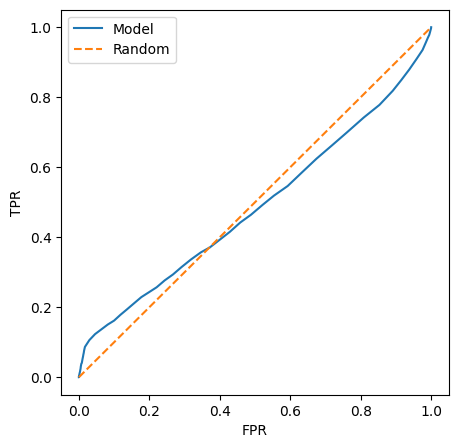

In [282]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [285]:
for score in df_train[numerical]:
    area_under_curve=roc_auc_score(y_train,df_train[score])
    if area_under_curve<0.5:
        area_under_curve=roc_auc_score(y_train,-df_train[score])
    print(score, area_under_curve)

age 0.512185717527344
balance 0.5888313805382317
day 0.525957882383908
duration 0.8147002759670778
campaign 0.5714543015682159
pdays 0.5901276247352144
previous 0.5985653242764153


Which numerical variable (among the following 4) has the highest AUC?

* balance
* day
* duration
* previous

In [286]:
# duration

### Question 2: Training the model
Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

In [287]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [288]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [289]:
len(y_pred)

9042

In [290]:
round(roc_auc_score(y_val, y_pred),3)

np.float64(0.901)

In [291]:
#roc_auc_score(y_pred, y_val)

In [292]:
# 0.90

### Question 3: Precision and Recall
Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [293]:
threshold=np.linspace(0,1.0, 101)

In [294]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.121
0.05 0.650
0.10 0.814
0.15 0.859
0.20 0.880
0.25 0.892
0.30 0.895
0.35 0.897
0.40 0.900
0.45 0.899
0.50 0.897
0.55 0.897
0.60 0.896
0.65 0.894
0.70 0.892
0.75 0.890
0.80 0.887
0.85 0.886
0.90 0.883
0.95 0.881
1.00 0.879


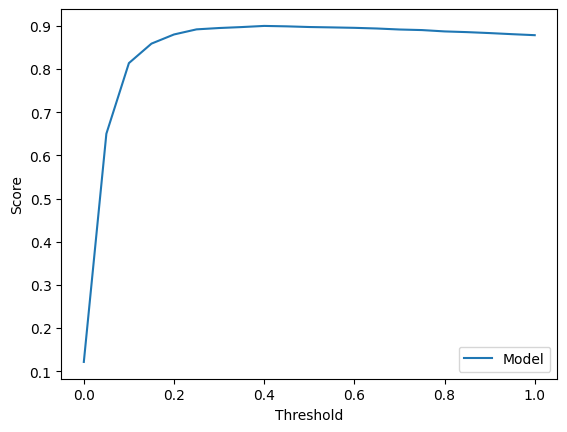

In [295]:
plt.plot(thresholds, scores, label='Model')

plt.xlabel('Threshold')
plt.ylabel('Score')

plt.legend()

In [296]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)
len(actual_positive), len(actual_negative)

(9042, 9042)

In [297]:
from collections import Counter
Counter(actual_positive),Counter(actual_negative)

(Counter({np.False_: 7944, np.True_: 1098}),
 Counter({np.True_: 7944, np.False_: 1098}))

In [298]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [299]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [300]:
confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[7753,  191],
       [ 736,  362]])

In [301]:
# precision
p = tp / (tp + fp)
p

np.float64(0.6546112115732369)

In [302]:
# recall
r = tp / (tp + fn)
r

np.float64(0.3296903460837887)

In [303]:
def precision_recall_dataframe(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)
    df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    
    return df_scores


In [304]:
df_model_eval=precision_recall_dataframe(y_val, y_pred)
df_model_eval.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   threshold  101 non-null    float64
 1   tp         101 non-null    int64  
 2   fp         101 non-null    int64  
 3   fn         101 non-null    int64  
 4   tn         101 non-null    int64  
 5   precision  100 non-null    float64
 6   recall     101 non-null    float64
dtypes: float64(3), int64(4)
memory usage: 5.7 KB


In [305]:
df_model_eval.isnull().sum() # there is a null value
# Filter rows where 'precision' is NaN
df_with_null_precision = df_model_eval[df_model_eval['precision'].isna()]
df_with_null_precision = df_model_eval[df_model_eval['precision'].isnull()]
print(df_with_null_precision)
df_model_eval.dropna(inplace=True)


     threshold  tp  fp    fn    tn  precision  recall
100        1.0   0   0  1098  7944        NaN     0.0


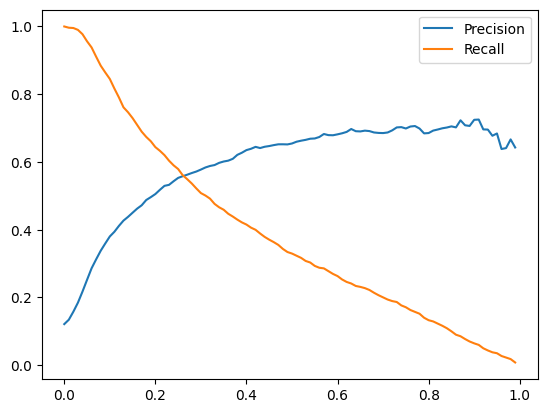

In [306]:
plt.plot(df_model_eval.threshold, df_model_eval['precision'], label='Precision')
plt.plot(df_model_eval.threshold, df_model_eval['recall'], label='Recall')
plt.legend();

At which threshold precision and recall curves intersect?

- 0.265   -answer
- 0.465
- 0.665
- 0.865

# Question 4: F1 score
Precision and recall are conflicting - when one grows, the other goes down. 
That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:




$F_1 = \frac{2 \cdot P \cdot R}{P + R}$


Where 
P
 is precision and 
R
 is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.02
- 0.22
- 0.42
- 0.62

In [208]:

df_model_eval['F1']=(2*df_model_eval.precision*df_model_eval.recall)/(df_model_eval.precision+df_model_eval.precision)

In [211]:
df_model_eval[df_model_eval.F1==df_model_eval.F1.max()]

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.0,1098,7944,0,0,0.121433,1.0,1.0


In [212]:
df_model_eval.head()

,threshold,tp,fp,fn,tn,precision,recall,F1
0,0.00,1098,7944,0,0,0.121433,1.000000,1.000000
1,0.01,1094,7046,4,898,0.134398,0.996357,0.996357
2,0.02,1093,5816,5,2128,0.158199,0.995446,0.995446
3,0.03,1087,4796,11,3148,0.184770,0.989982,0.989982
4,0.04,1073,3862,25,4082,0.217427,0.977231,0.977231


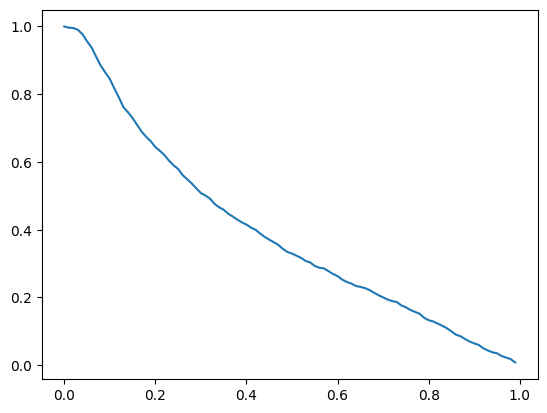

In [213]:
plt.plot(df_model_eval.threshold, df_model_eval['F1'], label='F1 Score')

In [310]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)
    
    return dv, model

In [328]:
dv, model = train(df_train, y_train, C=1.0)

C:\Users\user\miniconda3\envs\ml_study\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [329]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [330]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.00922069, 0.15751483, 0.10063857, ..., 0.07325451, 0.08462776,
       0.01225974])

In [331]:
from sklearn.model_selection import KFold

### Question 5: 5-Fold CV
Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)  
Iterate over different folds of df_full_train  
Split the data into train and validation  
Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)  
Use AUC to evaluate the model on validation  

In [332]:
from tqdm.auto import tqdm

n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in tqdm(kfold.split(df_train_full)):
    df_train = df_train_full.iloc[train_idx]
    df_val = df_train_full.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1.0)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

In [347]:
C

0.001

In [346]:
scores

[np.float64(0.8991383404784516),
 np.float64(0.8988658734459263),
 np.float64(0.9111639355164399),
 np.float64(0.9077330091880877),
 np.float64(0.9119645838566215)]

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06
- 0.26

In [341]:
#0.006

### Question 6: Hyperparameter Tuning
Now let's use 5-Fold cross-validation to find the best parameter C

Iterate over the following C values: [0.000001, 0.001, 1] 
Initialize KFold with the same parameters as previously  
Use these parameters for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)    
Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [350]:
n_splits = 5

for C in tqdm([0.000001,0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.824 +- 0.009
C=0.001 0.886 +- 0.005


C:\Users\user\miniconda3\envs\ml_study\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C=1 0.906 +- 0.006


In [351]:
scores

[np.float64(0.8991383404784516),
 np.float64(0.8988658734459263),
 np.float64(0.9111639355164399),
 np.float64(0.9077330091880877),
 np.float64(0.9119645838566215)]

Which C leads to the best mean score?

- 0.000001
- 0.001
- 1  
If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.